In [150]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path) 

#from importlib import reload  # Python 3.4+

import pickle
import pandas as pd
import matplotlib.pyplot as plt

#force reimport
if 'pygents.util' in sys.modules:
    del sys.modules['pygents.util']
if 'pygents.text' in sys.modules:
    del sys.modules['pygents.text']
if 'pygents.plot' in sys.modules:
    del sys.modules['pygents.plot']
if 'pygents.token' in sys.modules:
    del sys.modules['pygents.token']
if 'pygents.token_plot' in sys.modules:
    del sys.modules['pygents.token_plot']


from pygents.token import *
from pygents.text import *
from pygents.util import *
from pygents.plot import plot_bars, plot_dict, matrix_plot
from pygents.token_plot import *


In [2]:
#get raw lexicon list
en_lex = list(pd.read_csv("https://raw.githubusercontent.com/aigents/aigents-java/master/lexicon_english.txt",sep='\t',header=None,na_filter=False).to_records(index=False))
print(len(en_lex))

#debug raw lexicon
print(max(en_lex,key=lambda item:item[1]))
en_lex_dict = weightedlist2dict(en_lex,lower=True) # no case-insensitive merge
print(len(en_lex_dict))


97565
('the', 53097401)
97565


In [16]:
en_ref_tokenizer = PrefixSuffixMorphoTokenizerCached(["./data/corpora/English/morphology/prefixes.txt"],
                                   ["./data/corpora/English/morphology/suffixes.txt"])


In [28]:
texts = ['interestingly', # ['inter', 'est', 'ing', 'ly']
         'universities',
         'antidisestablishmentarianism', # anti-dis-establish-ment-ar-i-an-ism
         'decentralisations',
         'cities',
         'ping']
for text in texts:
    print(en_ref_tokenizer.tokenize(text)) 


['inter', 'est', 'ing', 'ly']
['uni', 'v', 'er', 's', 'ities']
['anti', 'dis', 'establ', 'ish', 'ment', 'arian', 'ism']
['dec', 'ent', 'rali', 's', 'ations']
['c', 'ities']
['p', 'ing']


In [34]:
base = FreedomTokenizer(name='data/models/lex_en_nocount_7',max_n=7,mode='chars',debug=False)
tf_tokenizer = FreedomBasedTokenizer(base,'peak-','peak+')
metrics = []
for n in [[7],[1,2,3,4,5,6,7]]:
    for t in [0.5,0.9,0.95]:
        tf_tokenizer.set_options(nlist = n, threshold=t)
        avg_f1 = 0
        print('---',n,t,'---')
        for text in texts:
            t0 = en_ref_tokenizer.tokenize(text)
            t1 = tf_tokenizer.tokenize(text)
            f1 = calc_f1(t0,t1)
            print(round(f1,2),t1)
            avg_f1 += f1
        avg_f1 /= len(texts)
        metrics.append((round(avg_f1,2),n,t))
for m in metrics:
    print(m)


--- [7] 0.5 ---
1.0 ['inter', 'est', 'ing', 'ly']
0 ['un', 'i', 'vers', 'it', 'ies']
0.36 ['anti', 'disestablishmentari', 'an', 'ism']
0 ['de', 'centr', 'alis', 'ati', 'ons']
0.33 ['c', 'i', 'ti', 'es']
0.4 ['p', 'in', 'g']
--- [7] 0.9 ---
0.57 ['inter', 'est', 'ingly']
0.5 ['uni', 'vers', 'ities']
0.4 ['anti', 'disestablishmentarian', 'ism']
0.25 ['de', 'centralis', 'ations']
0.4 ['c', 'i', 'ties']
0.4 ['p', 'in', 'g']
--- [7] 0.95 ---
0.57 ['inter', 'est', 'ingly']
0.5 ['uni', 'vers', 'ities']
0.4 ['anti', 'disestablishmentarian', 'ism']
0.25 ['de', 'centralis', 'ations']
0.4 ['c', 'i', 'ties']
0.4 ['p', 'in', 'g']
--- [1, 2, 3, 4, 5, 6, 7] 0.5 ---
1.0 ['inter', 'est', 'ing', 'ly']
0.4 ['un', 'i', 'v', 'ers', 'ities']
0.57 ['anti', 'dis', 'establish', 'ment', 'ari', 'an', 'ism']
0 ['de', 'centr', 'a', 'lis', 'ati', 'ons']
0.33 ['c', 'i', 'ti', 'es']
0.4 ['p', 'in', 'g']
--- [1, 2, 3, 4, 5, 6, 7] 0.9 ---
0.57 ['inter', 'est', 'ingly']
0.22 ['un', 'i', 'vers', 'ities']
0.4 ['anti', 'di

In [20]:
en_lex_dict['ping']

2011

In [21]:
en_lex_dict['ing']

15642

In [58]:
model_thresholds = [0]#,0.0001,0.001,0.01,0.1]
ngram_params = [[1],[2],[3],[4],[5],[6],[7],[1,2,3,4,5,6,7]]
token_thresholds = [0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99]


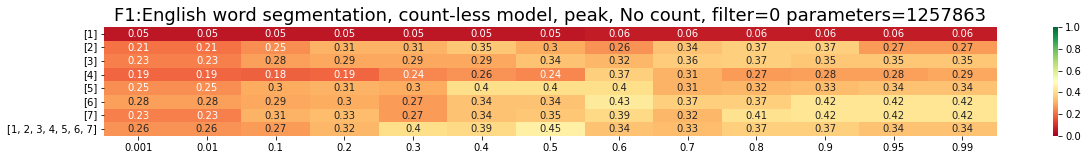

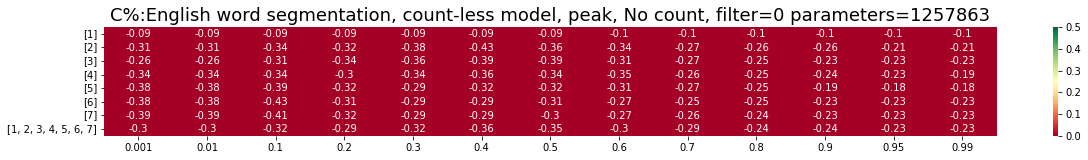

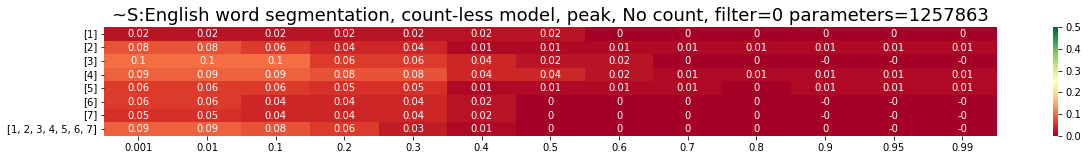

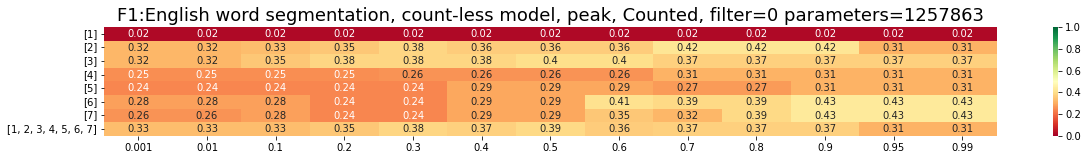

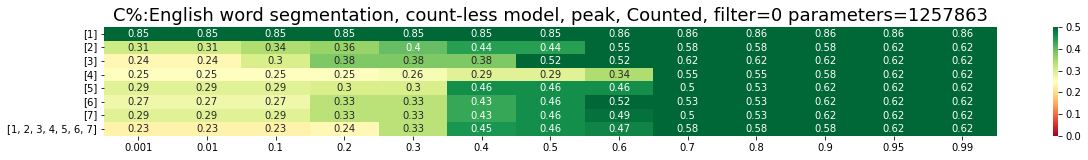

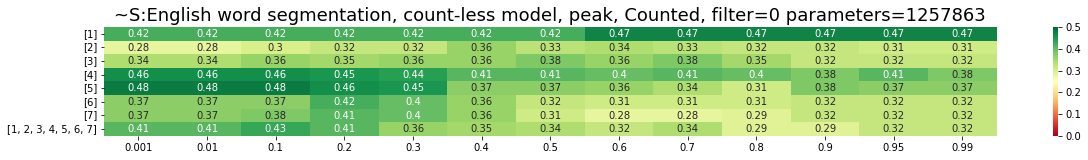

In [59]:
en_test_texts = texts
en_test_counts = [en_lex_dict[t] if t in en_lex_dict else 1 for t in texts]

metrics_en_list_20 = []

base = FreedomTokenizer(name='data/models/lex_en_nocount_7',max_n=7,mode='chars',debug=False)
title = 'English word segmentation, count-less model, peak'
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base.model,model_threshold)
    parameters = base.count_params()
    metrics = evaluate_freedom_tokenizer_multimetrics(en_test_texts,en_ref_tokenizer,FreedomBasedTokenizer(base,'peak-','peak+'),
        ngram_params,token_thresholds,title="{}, No count, filter={} parameters={}".format(title,model_threshold,parameters)
        ,test_counts=None)
    metrics_en_list_20.extend([('peak',model_threshold,m[0],m[1],m[2],m[3],m[4]) for m in metrics])
del base

base = FreedomTokenizer(name='data/models/lex_en_nocount_7',max_n=7,mode='chars',debug=False)
title = 'English word segmentation, count-less model, peak'
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base.model,model_threshold)
    parameters = base.count_params()
    metrics = evaluate_freedom_tokenizer_multimetrics(en_test_texts,en_ref_tokenizer,FreedomBasedTokenizer(base,'peak-','peak+'),
        ngram_params,token_thresholds,title="{}, Counted, filter={} parameters={}".format(title,model_threshold,parameters)
        ,test_counts=en_test_counts)
    metrics_en_list_20.extend([('peak',model_threshold,m[0],m[1],m[2],m[3],m[4]) for m in metrics])
del base


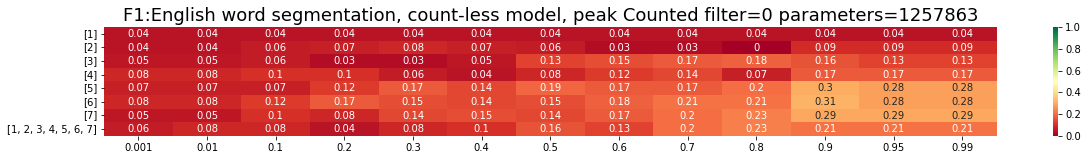

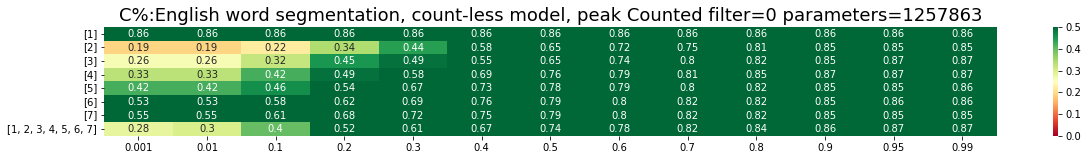

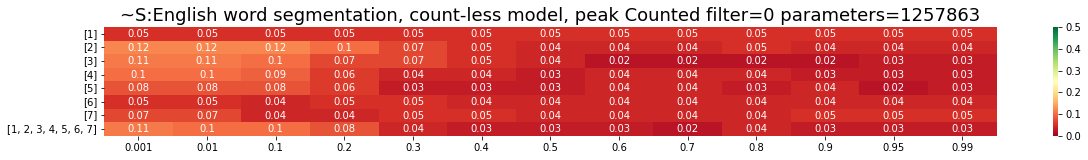

In [60]:
en_test_texts = [t for t in en_lex_dict if len(t) > 20]
en_test_counts = [en_lex_dict[t] for t in en_lex_dict if len(t) > 20]

metrics_en_list_20 = []

base = FreedomTokenizer(name='data/models/lex_en_nocount_7',max_n=7,mode='chars',debug=False)
title = 'English word segmentation, count-less model, peak'
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base.model,model_threshold)
    parameters = base.count_params()
    metrics = evaluate_freedom_tokenizer_multimetrics(en_test_texts,en_ref_tokenizer,FreedomBasedTokenizer(base,'peak-','peak+'),
        ngram_params,token_thresholds,title="{} Counted filter={} parameters={}".format(title,model_threshold,parameters)
        ,test_counts=en_test_counts)
    metrics_en_list_20.extend([('peak',model_threshold,m[0],m[1],m[2],m[3],m[4]) for m in metrics])
del base


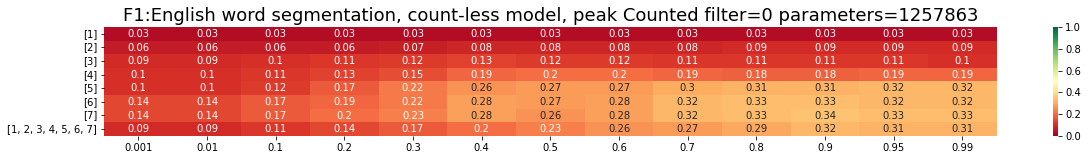

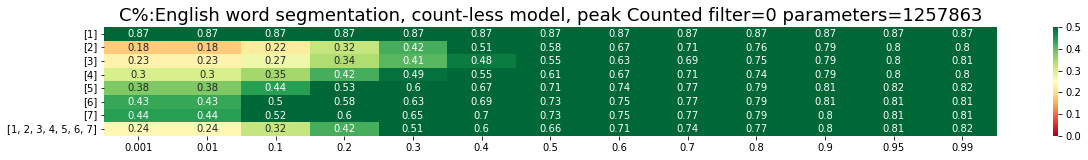

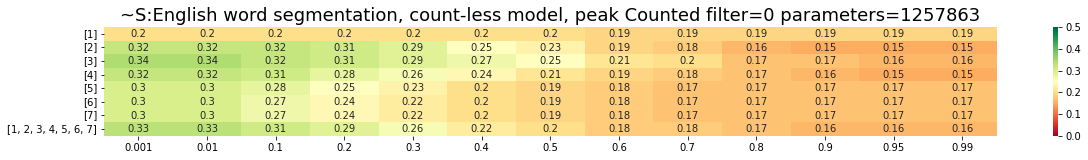

In [61]:
en_test_texts = [t for t in en_lex_dict if len(t) > 15]
en_test_counts = [en_lex_dict[t] for t in en_lex_dict if len(t) > 15]

metrics_en_list_15 = []

base = FreedomTokenizer(name='data/models/lex_en_nocount_7',max_n=7,mode='chars',debug=False)
title = 'English word segmentation, count-less model, peak'
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base.model,model_threshold)
    parameters = base.count_params()
    metrics = evaluate_freedom_tokenizer_multimetrics(en_test_texts,en_ref_tokenizer,FreedomBasedTokenizer(base,'peak-','peak+'),
        ngram_params,token_thresholds,title="{} Counted filter={} parameters={}".format(title,model_threshold,parameters)
        ,test_counts=en_test_counts)
    metrics_en_list_15.extend([('peak',model_threshold,m[0],m[1],m[2],m[3],m[4]) for m in metrics])
del base



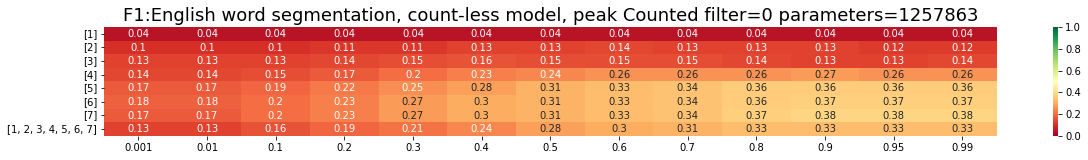

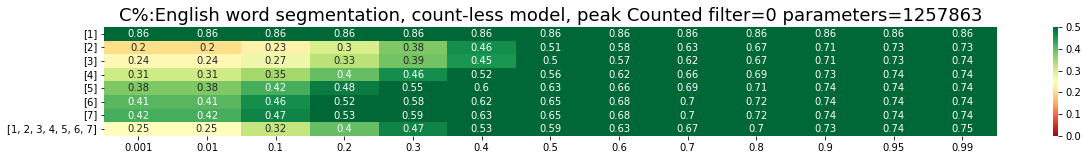

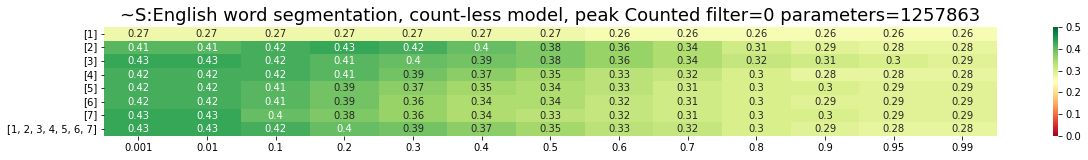

In [62]:
en_test_texts = [t for t in en_lex_dict if len(t) > 10]
en_test_counts = [en_lex_dict[t] for t in en_lex_dict if len(t) > 10]

metrics_en_list_10 = []

base = FreedomTokenizer(name='data/models/lex_en_nocount_7',max_n=7,mode='chars',debug=False)
title = 'English word segmentation, count-less model, peak'
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base.model,model_threshold)
    parameters = base.count_params()
    metrics = evaluate_freedom_tokenizer_multimetrics(en_test_texts,en_ref_tokenizer,FreedomBasedTokenizer(base,'peak-','peak+'),
        ngram_params,token_thresholds,title="{} Counted filter={} parameters={}".format(title,model_threshold,parameters)
        ,test_counts=en_test_counts)
    metrics_en_list_10.extend([('peak',model_threshold,m[0],m[1],m[2],m[3],m[4]) for m in metrics])
del base



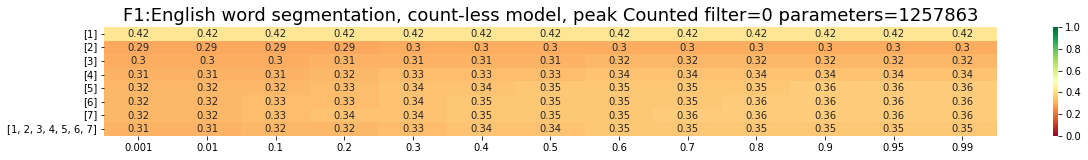

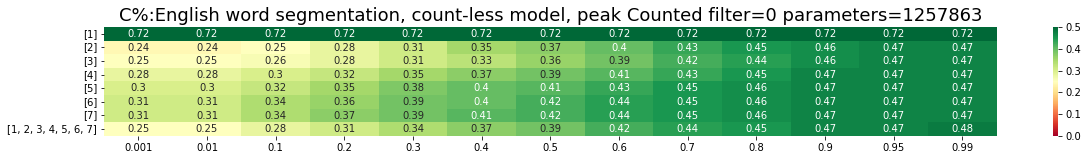

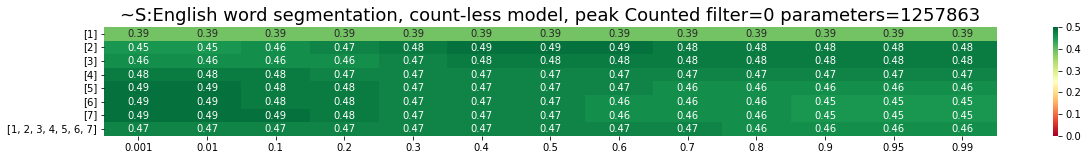

In [73]:
en_test_texts =  [t for t in en_lex_dict]
en_test_counts = [en_lex_dict[t] for t in en_lex_dict]

metrics_en_list_all = []

base = FreedomTokenizer(name='data/models/lex_en_nocount_7',max_n=7,mode='chars',debug=False)
title = 'English word segmentation, count-less model, peak'
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base.model,model_threshold)
    parameters = base.count_params()
    metrics = evaluate_freedom_tokenizer_multimetrics(en_test_texts,en_ref_tokenizer,FreedomBasedTokenizer(base,'peak-','peak+'),
        ngram_params,token_thresholds,title="{} Counted filter={} parameters={}".format(title,model_threshold,parameters)
        ,test_counts=en_test_counts)
    metrics_en_list_all.extend([('peak',model_threshold,m[0],m[1],m[2],m[3],m[4]) for m in metrics])
del base


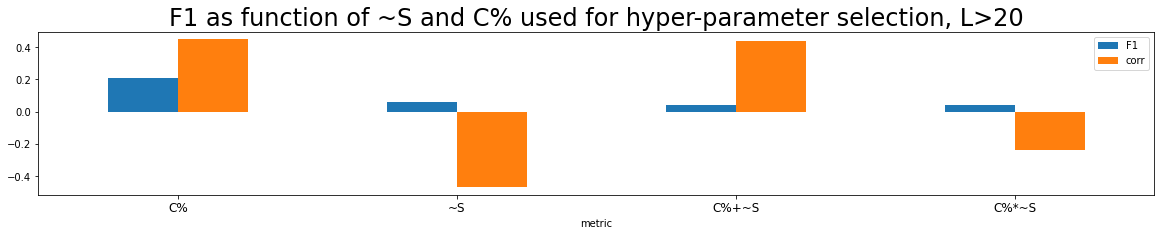

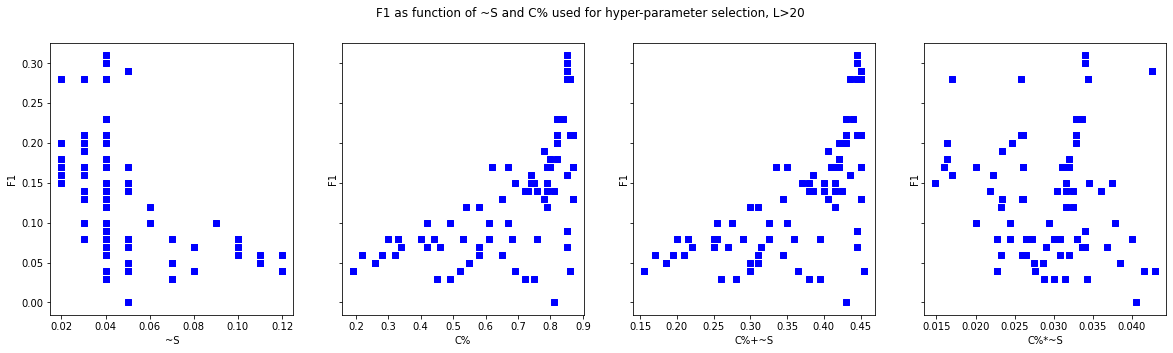

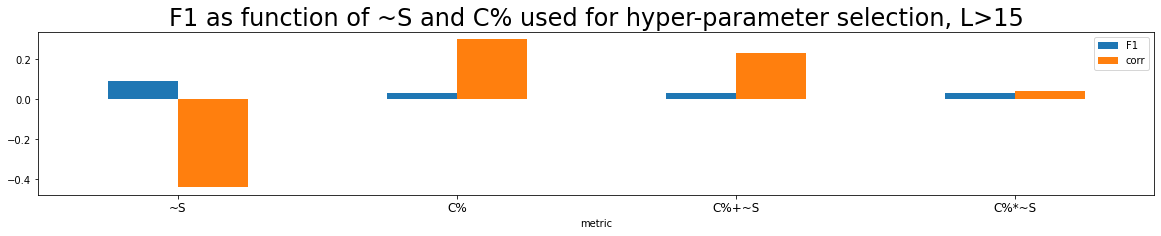

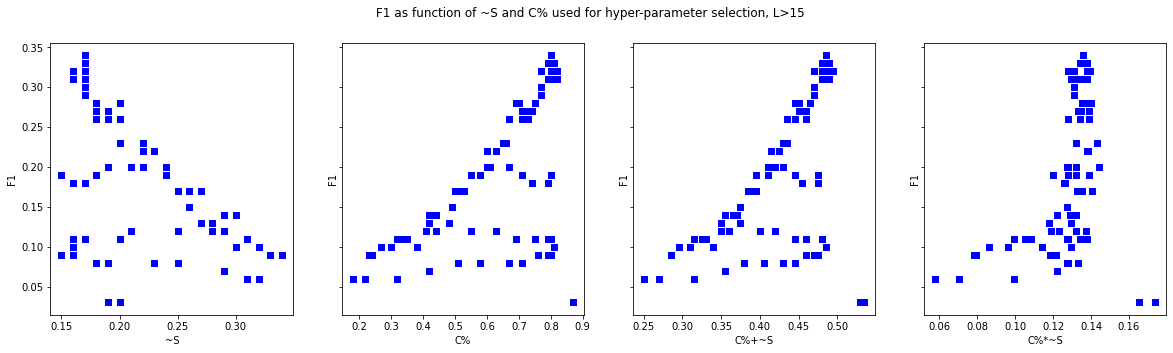

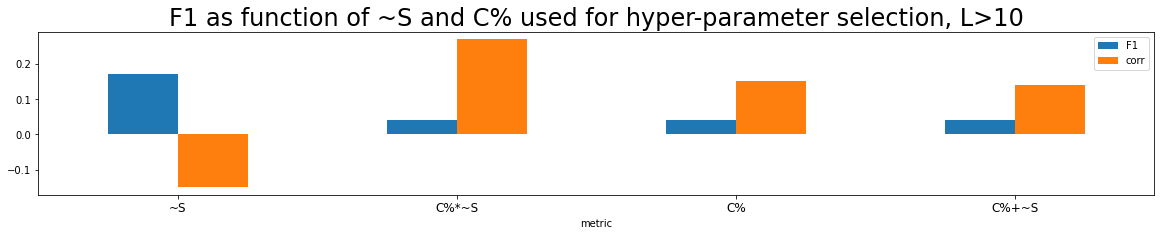

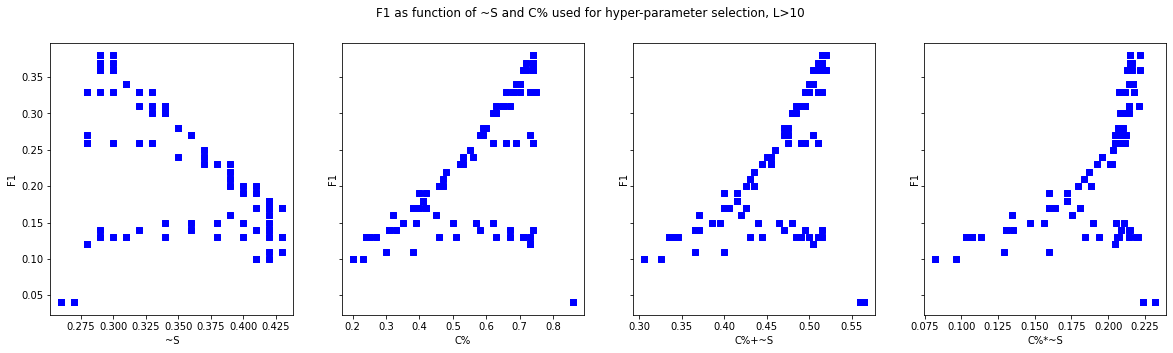

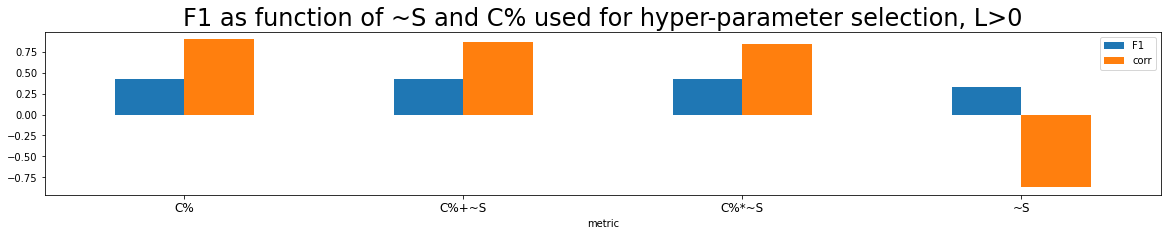

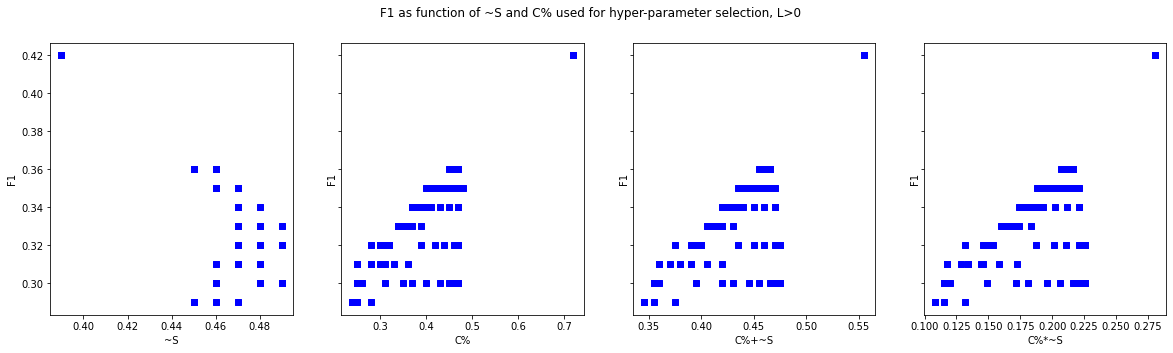

In [74]:
for metrics, l in zip([metrics_en_list_20,metrics_en_list_15,metrics_en_list_10,metrics_en_list_all],[20,15,10,0]):
    
    title = 'F1 as function of ~S and C% used for hyper-parameter selection, L>'+str(l)

    m_df = pd.DataFrame(metrics,columns=['TM','MT','NG','TT','F1','C%','~S'])
    m_df['C%+~S'] = (m_df['C%'] + m_df['~S'])/2
    m_df['C%*~S'] = (m_df['C%'] * m_df['~S'])

    #print('F1 X C%',m_df['F1'].corr(m_df['C%']))
    #print('F1 X ~S',m_df['F1'].corr(m_df['~S']))
    #print('~S X C%',m_df['~S'].corr(m_df['C%']))

    top_df = None
    for m in ['~S','C%','C%+~S','C%*~S']:
        df = m_df.sort_values(by=[m,'F1'],ascending=False)[['F1']][:1]
        df.insert(0,'metric',[m])
        df.insert(2,'corr',[round(m_df['F1'].corr(m_df[m]),2)])
        if top_df is None:
            top_df = df
        else:
            top_df = top_df.append(df)
    top_df.sort_values(by=['F1','corr','metric'],ascending=False,inplace=True)

    plot_bars(top_df,'metric',['F1','corr'],title=title,fontsize=12)
    plt.show()

    fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

    axs[0].scatter(m_df['~S'], m_df['F1'], c ="blue", marker ="s")
    axs[0].set_xlabel("~S")
    axs[0].set_ylabel("F1")

    axs[1].scatter(m_df['C%'], m_df['F1'], c ="blue", marker ="s")
    axs[1].set_xlabel("C%")
    axs[1].set_ylabel("F1")

    axs[2].scatter(m_df['C%+~S'], m_df['F1'], c ="blue", marker ="s")
    axs[2].set_xlabel("C%+~S")
    axs[2].set_ylabel("F1")

    axs[3].scatter(m_df['C%*~S'], m_df['F1'], c ="blue", marker ="s")
    axs[3].set_xlabel("C%*~S")
    axs[3].set_ylabel("F1")

    p = fig.suptitle(title)   


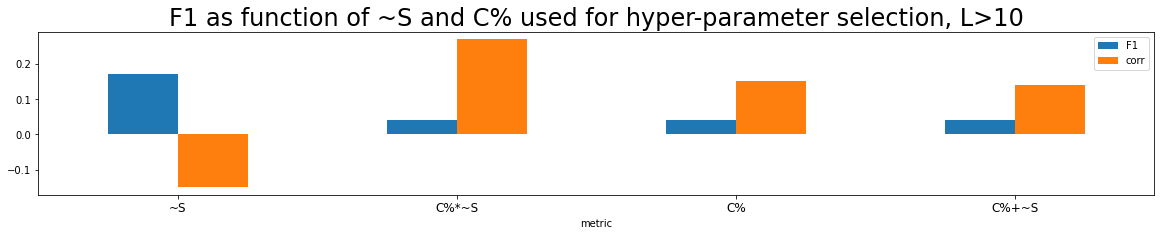

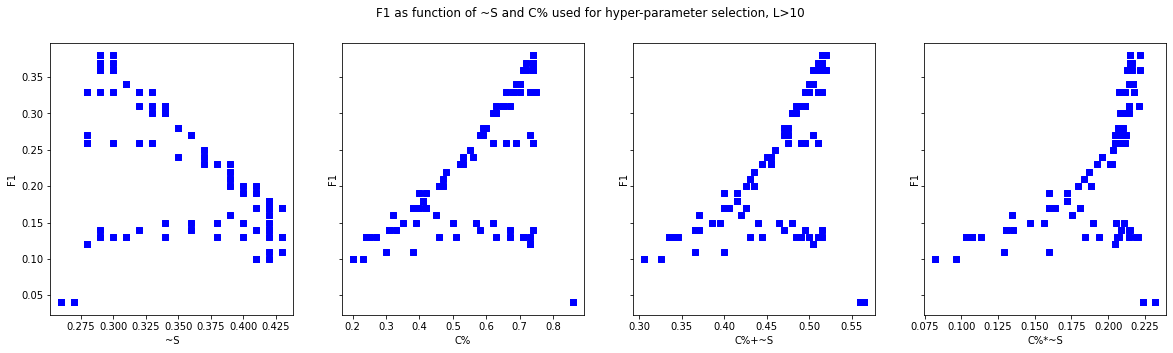

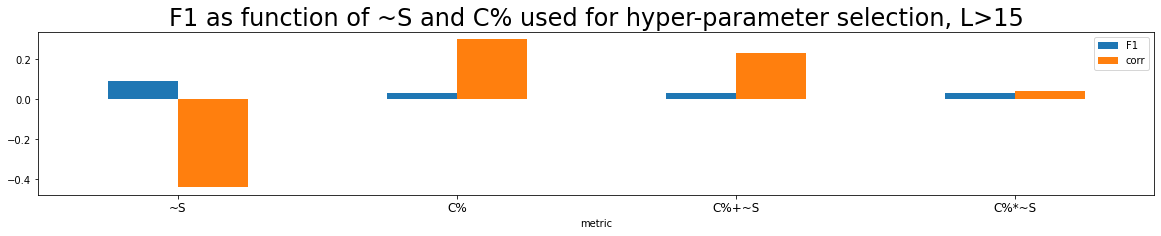

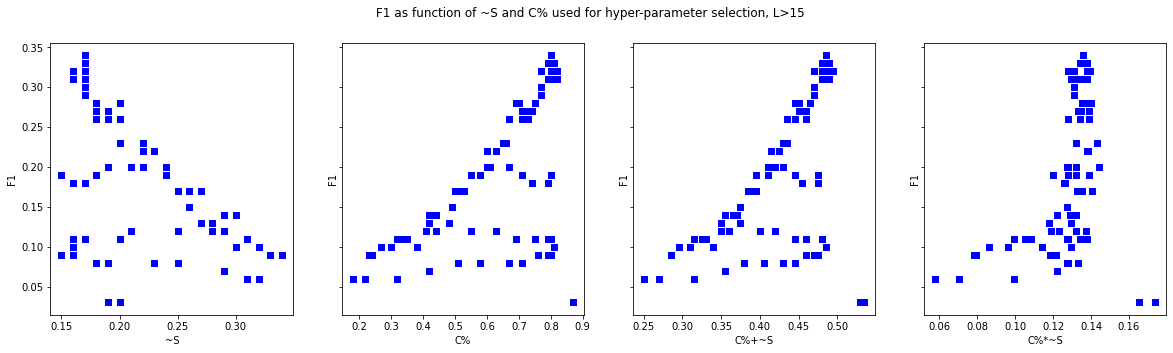

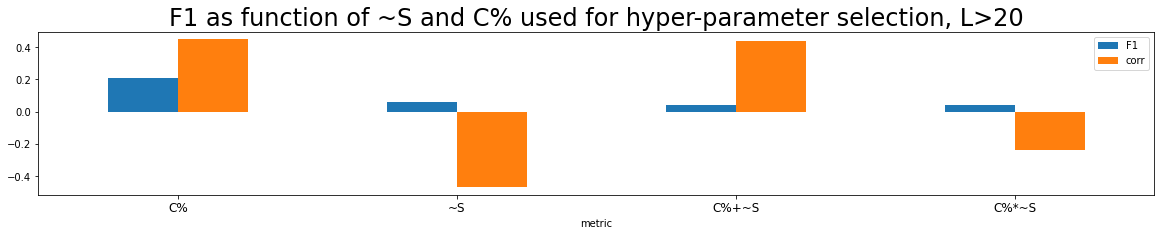

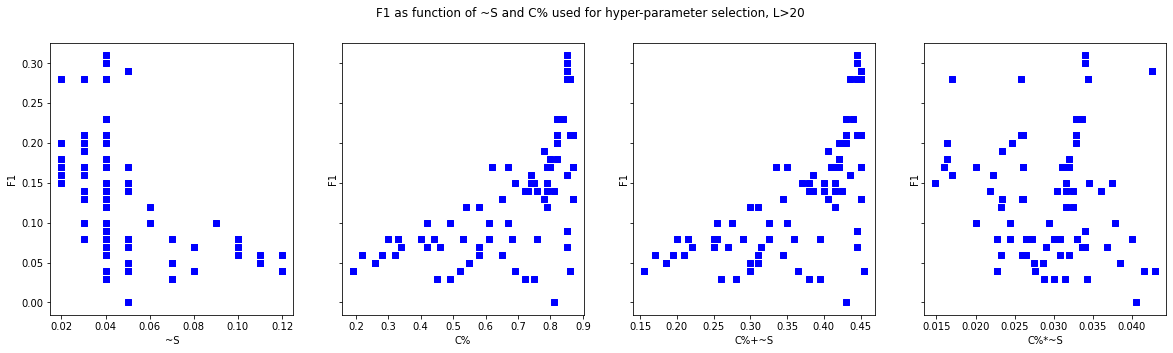

In [71]:
for metrics, l in zip([metrics_en_list_20,metrics_en_list_15,metrics_en_list_10,metrics_en_list_all],[20,15,10,0]):
    
    title = 'F1 as function of ~S and C% used for hyper-parameter selection, L>'+str(l)

    m_df = pd.DataFrame(metrics,columns=['TM','MT','NG','TT','F1','C%','~S'])
    m_df['C%+~S'] = (m_df['C%'] + m_df['~S'])/2
    m_df['C%*~S'] = (m_df['C%'] * m_df['~S'])

    #print('F1 X C%',m_df['F1'].corr(m_df['C%']))
    #print('F1 X ~S',m_df['F1'].corr(m_df['~S']))
    #print('~S X C%',m_df['~S'].corr(m_df['C%']))

    top_df = None
    for m in ['~S','C%','C%+~S','C%*~S']:
        df = m_df.sort_values(by=[m,'F1'],ascending=False)[['F1']][:1]
        df.insert(0,'metric',[m])
        df.insert(2,'corr',[round(m_df['F1'].corr(m_df[m]),2)])
        if top_df is None:
            top_df = df
        else:
            top_df = top_df.append(df)
    top_df.sort_values(by=['F1','corr','metric'],ascending=False,inplace=True)

    plot_bars(top_df,'metric',['F1','corr'],title=title,fontsize=12)
    plt.show()

    fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

    axs[0].scatter(m_df['~S'], m_df['F1'], c ="blue", marker ="s")
    axs[0].set_xlabel("~S")
    axs[0].set_ylabel("F1")

    axs[1].scatter(m_df['C%'], m_df['F1'], c ="blue", marker ="s")
    axs[1].set_xlabel("C%")
    axs[1].set_ylabel("F1")

    axs[2].scatter(m_df['C%+~S'], m_df['F1'], c ="blue", marker ="s")
    axs[2].set_xlabel("C%+~S")
    axs[2].set_ylabel("F1")

    axs[3].scatter(m_df['C%*~S'], m_df['F1'], c ="blue", marker ="s")
    axs[3].set_xlabel("C%*~S")
    axs[3].set_ylabel("F1")

    p = fig.suptitle(title)   


## Max sequence length = 10

In [79]:
ngram_params = [[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]]


In [80]:
lex_en_base10 = FreedomTokenizer(max_n=10,mode='chars',debug=False)
lex_en_base10.train(en_lex_dict)
lex_en_base10.store('data/models/lex_en_counted_10')
print(lex_en_base10.count_params())


1684498


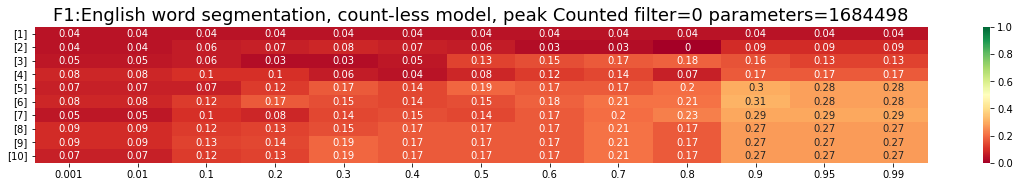

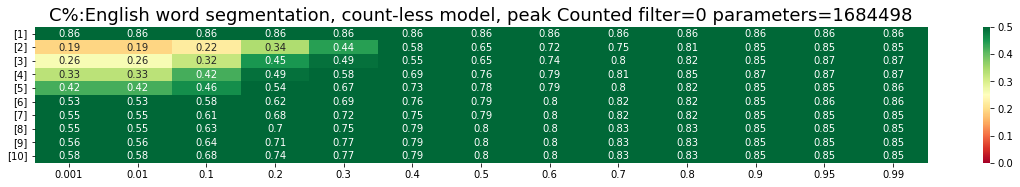

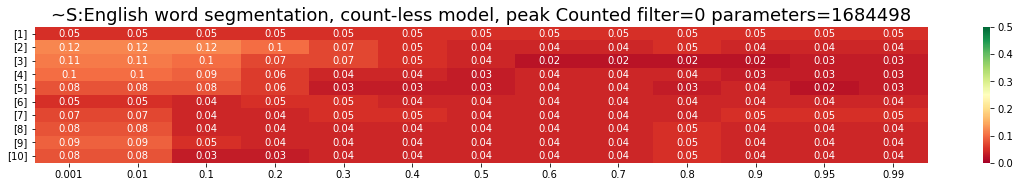

In [81]:
en_test_texts = [t for t in en_lex_dict if len(t) > 20]
en_test_counts = [en_lex_dict[t] for t in en_lex_dict if len(t) > 20]

metrics_en_list10_20 = []

base = FreedomTokenizer(name='data/models/lex_en_counted_10',max_n=7,mode='chars',debug=False)
title = 'English word segmentation, count-less model, peak'
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base.model,model_threshold)
    parameters = base.count_params()
    metrics = evaluate_freedom_tokenizer_multimetrics(en_test_texts,en_ref_tokenizer,FreedomBasedTokenizer(base,'peak-','peak+'),
        ngram_params,token_thresholds,title="{} Counted filter={} parameters={}".format(title,model_threshold,parameters)
        ,test_counts=en_test_counts)
    metrics_en_list10_20.extend([('peak',model_threshold,m[0],m[1],m[2],m[3],m[4]) for m in metrics])
del base


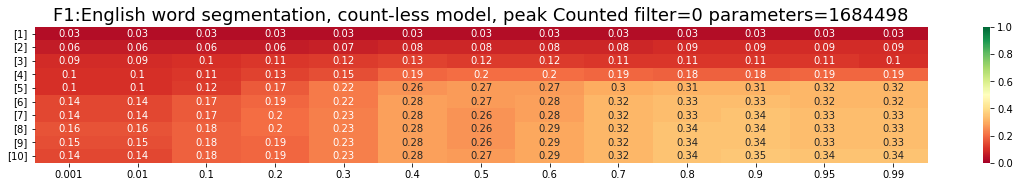

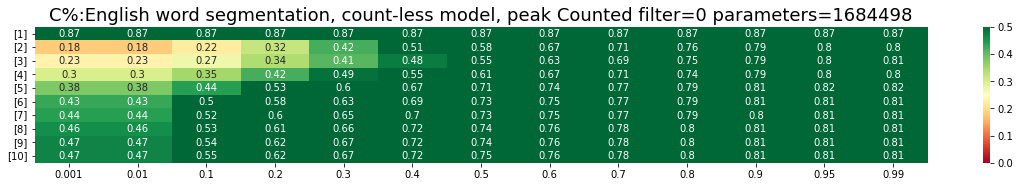

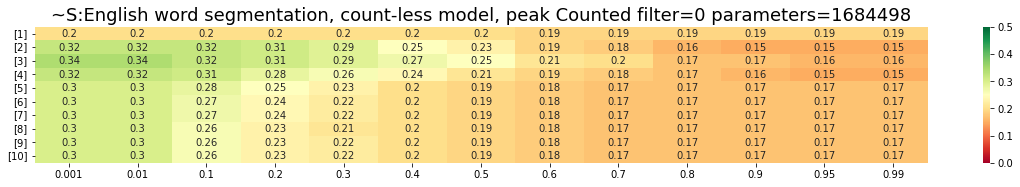

In [82]:
en_test_texts = [t for t in en_lex_dict if len(t) > 15]
en_test_counts = [en_lex_dict[t] for t in en_lex_dict if len(t) > 15]

metrics_en_list10_15 = []

base = FreedomTokenizer(name='data/models/lex_en_counted_10',max_n=7,mode='chars',debug=False)
title = 'English word segmentation, count-less model, peak'
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base.model,model_threshold)
    parameters = base.count_params()
    metrics = evaluate_freedom_tokenizer_multimetrics(en_test_texts,en_ref_tokenizer,FreedomBasedTokenizer(base,'peak-','peak+'),
        ngram_params,token_thresholds,title="{} Counted filter={} parameters={}".format(title,model_threshold,parameters)
        ,test_counts=en_test_counts)
    metrics_en_list10_15.extend([('peak',model_threshold,m[0],m[1],m[2],m[3],m[4]) for m in metrics])
del base


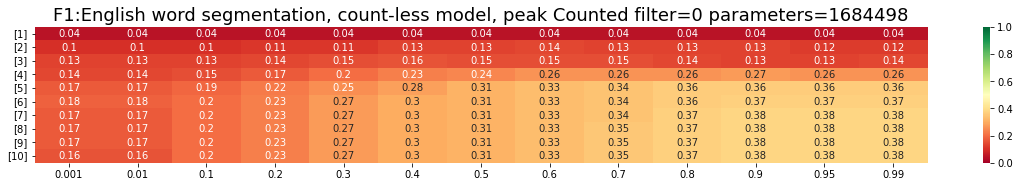

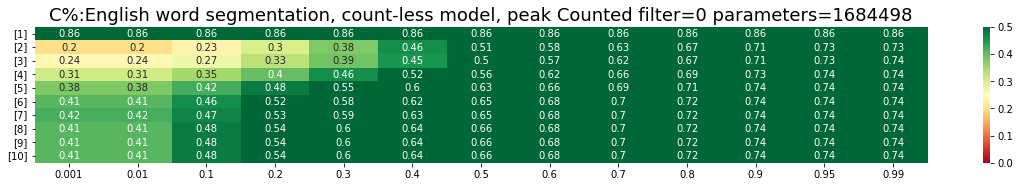

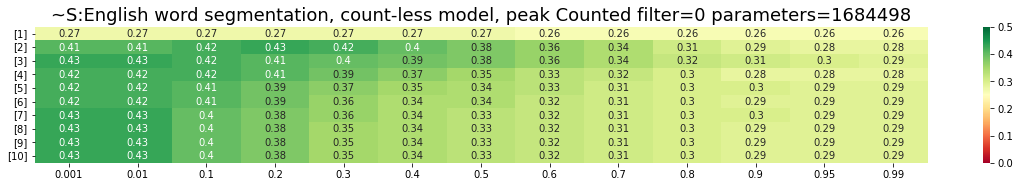

In [83]:
en_test_texts = [t for t in en_lex_dict if len(t) > 10]
en_test_counts = [en_lex_dict[t] for t in en_lex_dict if len(t) > 10]

metrics_en_list10_10 = []

base = FreedomTokenizer(name='data/models/lex_en_counted_10',max_n=7,mode='chars',debug=False)
title = 'English word segmentation, count-less model, peak'
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base.model,model_threshold)
    parameters = base.count_params()
    metrics = evaluate_freedom_tokenizer_multimetrics(en_test_texts,en_ref_tokenizer,FreedomBasedTokenizer(base,'peak-','peak+'),
        ngram_params,token_thresholds,title="{} Counted filter={} parameters={}".format(title,model_threshold,parameters)
        ,test_counts=en_test_counts)
    metrics_en_list10_10.extend([('peak',model_threshold,m[0],m[1],m[2],m[3],m[4]) for m in metrics])
del base


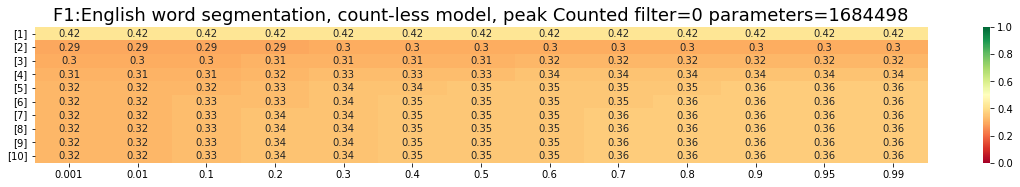

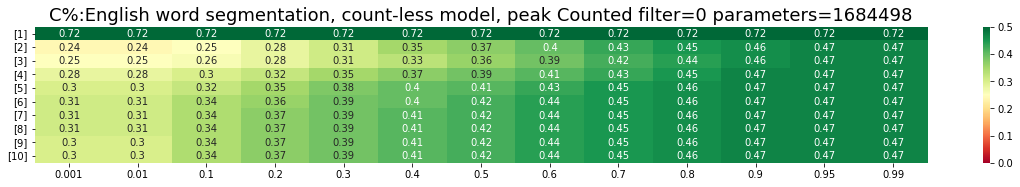

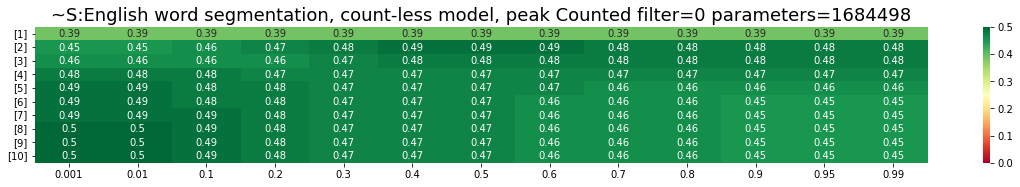

In [84]:
en_test_texts = [t for t in en_lex_dict if len(t) > 0]
en_test_counts = [en_lex_dict[t] for t in en_lex_dict if len(t) > 0]

metrics_en_list10_all = []

base = FreedomTokenizer(name='data/models/lex_en_counted_10',max_n=7,mode='chars',debug=False)
title = 'English word segmentation, count-less model, peak'
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base.model,model_threshold)
    parameters = base.count_params()
    metrics = evaluate_freedom_tokenizer_multimetrics(en_test_texts,en_ref_tokenizer,FreedomBasedTokenizer(base,'peak-','peak+'),
        ngram_params,token_thresholds,title="{} Counted filter={} parameters={}".format(title,model_threshold,parameters)
        ,test_counts=en_test_counts)
    metrics_en_list10_all.extend([('peak',model_threshold,m[0],m[1],m[2],m[3],m[4]) for m in metrics])
del base


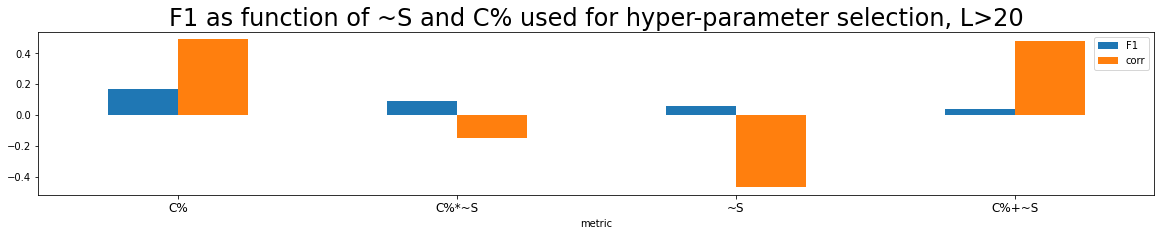

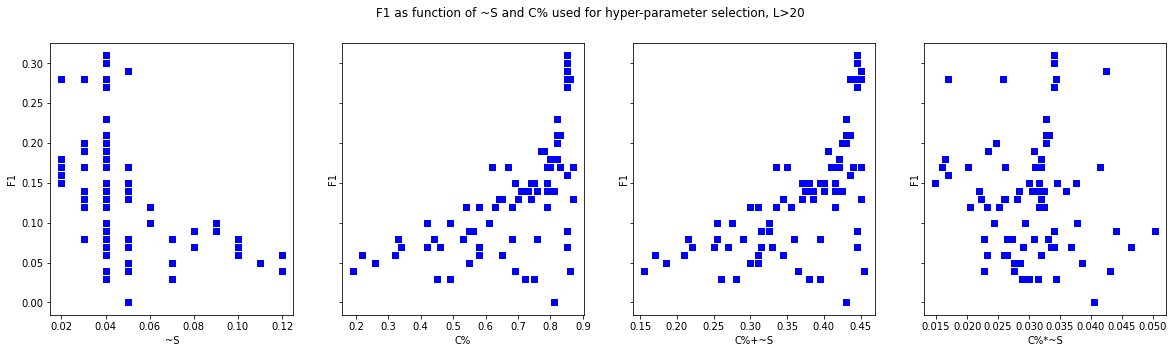

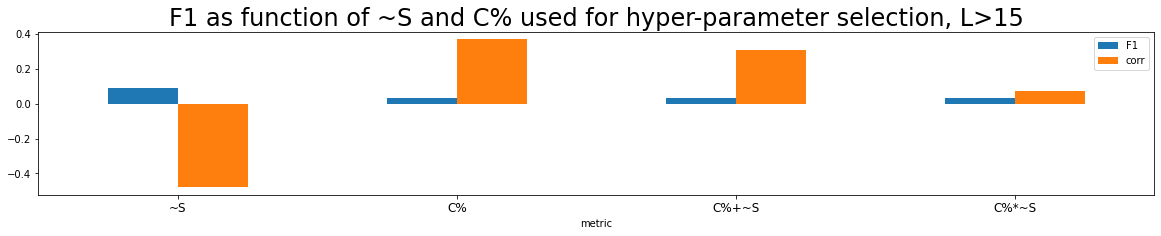

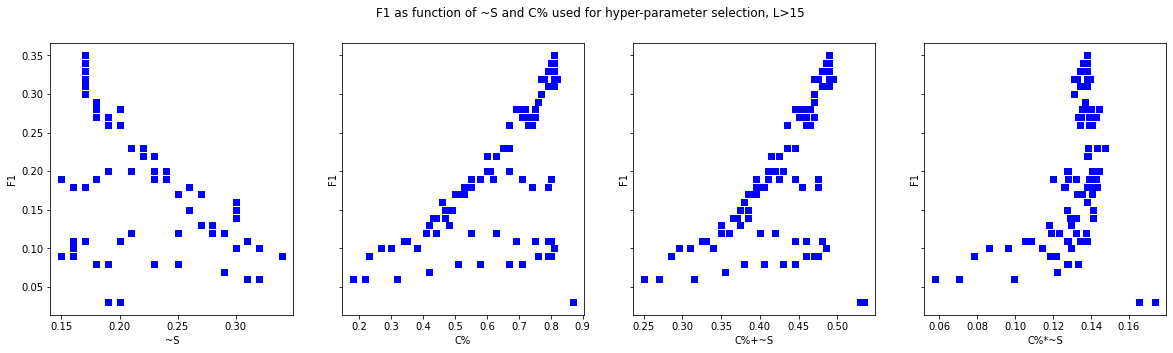

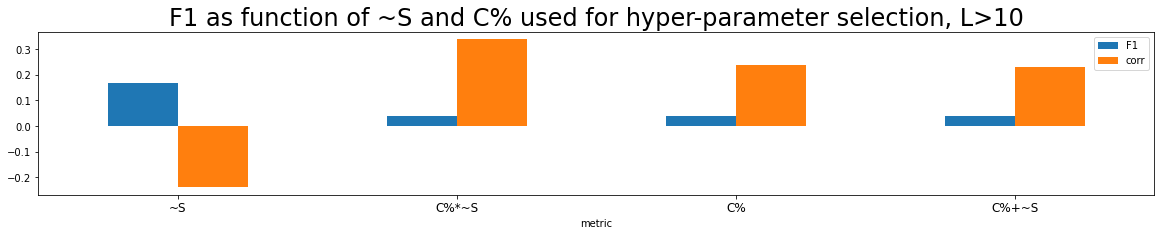

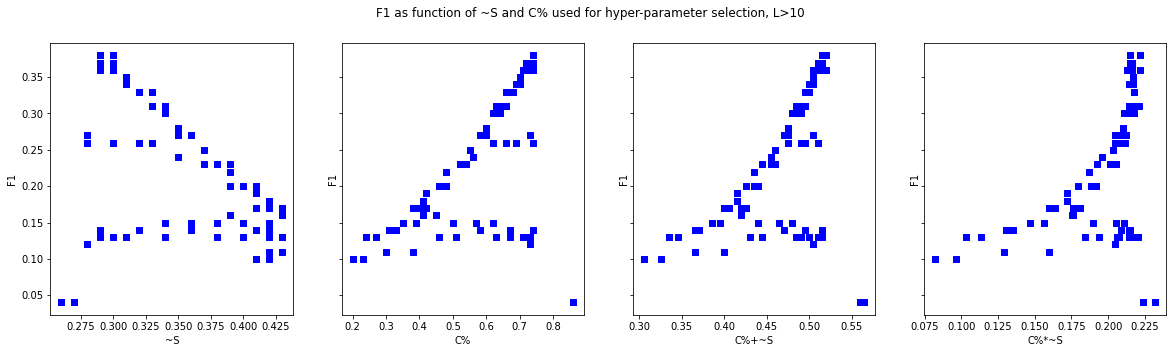

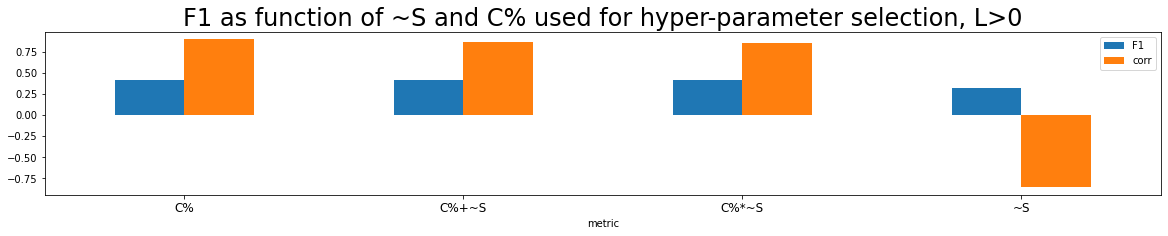

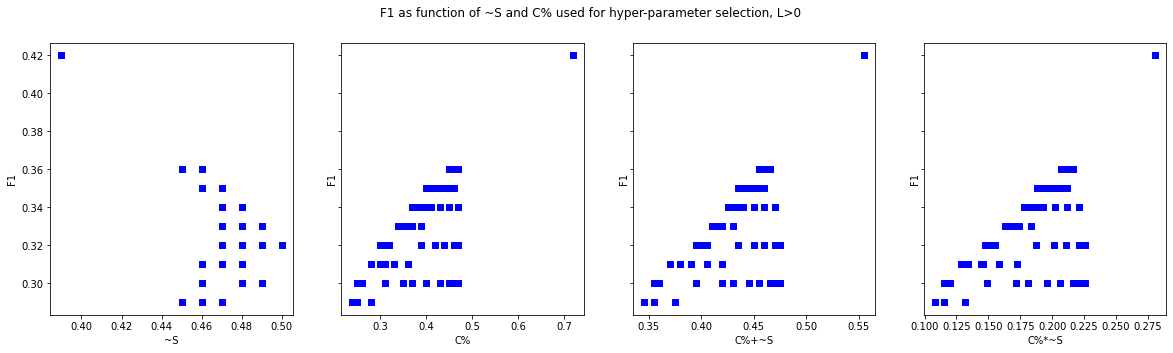

In [85]:
for metrics, l in zip([metrics_en_list10_20,metrics_en_list10_15,metrics_en_list10_10,metrics_en_list10_all],[20,15,10,0]):
    
    title = 'F1 as function of ~S and C% used for hyper-parameter selection, L>'+str(l)

    m_df = pd.DataFrame(metrics,columns=['TM','MT','NG','TT','F1','C%','~S'])
    m_df['C%+~S'] = (m_df['C%'] + m_df['~S'])/2
    m_df['C%*~S'] = (m_df['C%'] * m_df['~S'])

    #print('F1 X C%',m_df['F1'].corr(m_df['C%']))
    #print('F1 X ~S',m_df['F1'].corr(m_df['~S']))
    #print('~S X C%',m_df['~S'].corr(m_df['C%']))

    top_df = None
    for m in ['~S','C%','C%+~S','C%*~S']:
        df = m_df.sort_values(by=[m,'F1'],ascending=False)[['F1']][:1]
        df.insert(0,'metric',[m])
        df.insert(2,'corr',[round(m_df['F1'].corr(m_df[m]),2)])
        if top_df is None:
            top_df = df
        else:
            top_df = top_df.append(df)
    top_df.sort_values(by=['F1','corr','metric'],ascending=False,inplace=True)

    plot_bars(top_df,'metric',['F1','corr'],title=title,fontsize=12)
    plt.show()

    fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

    axs[0].scatter(m_df['~S'], m_df['F1'], c ="blue", marker ="s")
    axs[0].set_xlabel("~S")
    axs[0].set_ylabel("F1")

    axs[1].scatter(m_df['C%'], m_df['F1'], c ="blue", marker ="s")
    axs[1].set_xlabel("C%")
    axs[1].set_ylabel("F1")

    axs[2].scatter(m_df['C%+~S'], m_df['F1'], c ="blue", marker ="s")
    axs[2].set_xlabel("C%+~S")
    axs[2].set_ylabel("F1")

    axs[3].scatter(m_df['C%*~S'], m_df['F1'], c ="blue", marker ="s")
    axs[3].set_xlabel("C%*~S")
    axs[3].set_ylabel("F1")

    p = fig.suptitle(title)   


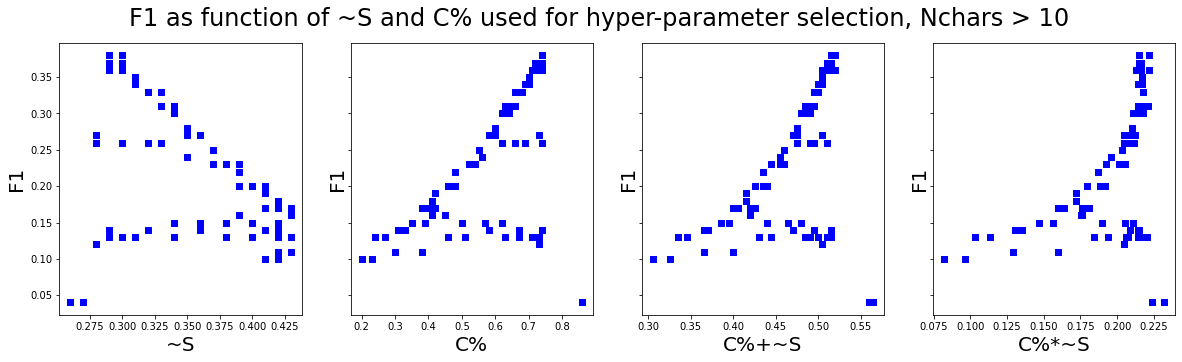

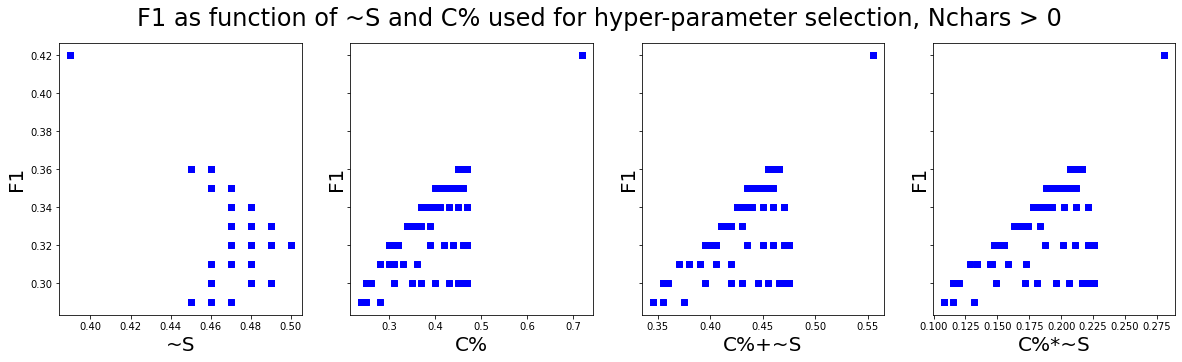

In [94]:
for metrics, l in zip([metrics_en_list10_10,metrics_en_list10_all],[10,0]):
    
    title = 'F1 as function of ~S and C% used for hyper-parameter selection, Nchars > '+str(l)

    m_df = pd.DataFrame(metrics,columns=['TM','MT','NG','TT','F1','C%','~S'])
    m_df['C%+~S'] = (m_df['C%'] + m_df['~S'])/2
    m_df['C%*~S'] = (m_df['C%'] * m_df['~S'])

    fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

    axs[0].scatter(m_df['~S'], m_df['F1'], c ="blue", marker ="s")
    axs[0].set_xlabel("~S",fontsize=20)
    axs[0].set_ylabel("F1",fontsize=20)

    axs[1].scatter(m_df['C%'], m_df['F1'], c ="blue", marker ="s")
    axs[1].set_xlabel("C%",fontsize=20)
    axs[1].set_ylabel("F1",fontsize=20)

    axs[2].scatter(m_df['C%+~S'], m_df['F1'], c ="blue", marker ="s")
    axs[2].set_xlabel("C%+~S",fontsize=20)
    axs[2].set_ylabel("F1",fontsize=20)

    axs[3].scatter(m_df['C%*~S'], m_df['F1'], c ="blue", marker ="s")
    axs[3].set_xlabel("C%*~S",fontsize=20)
    axs[3].set_ylabel("F1",fontsize=20)

    p = fig.suptitle(title,fontsize=24) 

## Explore morpho-analysis with account to word boundaries

In [144]:
en_lex_dict_ = {}
for e in en_lex_dict:
    en_lex_dict_['_'+e+'_'] = en_lex_dict[e]

In [108]:
lex_en_base10_ = FreedomTokenizer(max_n=10,mode='chars',debug=False)
lex_en_base10_.train(en_lex_dict_)
lex_en_base10_.store('data/models/lex_en_counted_10_')
print(lex_en_base10_.count_params())


3175832


In [145]:
base = FreedomTokenizer(name='data/models/lex_en_counted_10_',max_n=7,mode='chars',debug=False)
title = 'English word segmentation, count-less model, peak'
tf_tokenizer = FreedomBasedTokenizer(base,'peak-','peak+')
n = [7]
t = 0.9
tf_tokenizer.set_options(nlist = n, threshold=t)


In [146]:
print(tf_tokenizer.tokenize('tokenization'))
print(tf_tokenizer.tokenize('_tokenization_'))


['to', 'keniz', 'ation']
['_to', 'keniz', 'ation_']


In [147]:
base_ = FreedomTokenizer(name='data/models/lex_en_counted_10_',max_n=7,mode='chars',debug=False)
tf_tokenizer_ = FreedomBasedTokenizerWithWordBoundaries(base, 'peak-','peak+', nlist=[7], threshold=0.9)


In [148]:
print(tf_tokenizer.tokenize('wines'))
print(tf_tokenizer_.tokenize('wines'))
print(tf_tokenizer.tokenize('preventative'))
print(tf_tokenizer_.tokenize('preventative'))
print(tf_tokenizer.tokenize('entrepreneurship'))
print(tf_tokenizer_.tokenize('entrepreneurship'))


['w', 'i', 'n', 'es']
['w', 'ines']
['pre', 'vent', 'ative']
['pre', 'ventativ', 'e']
['entre', 'preneur', 'sh', 'ip']
['entre', 'preneur', 'ship']


## Hyper-parameters for morpho-analysis with account to word boundaries

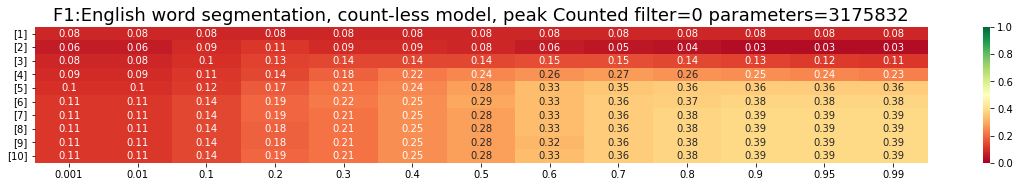

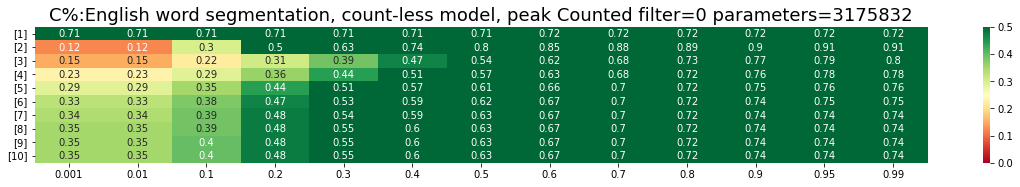

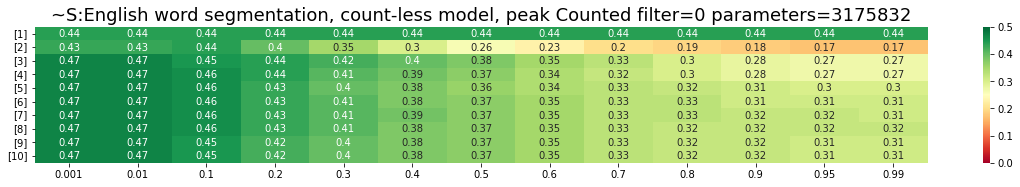

In [151]:
en_test_texts = [t for t in en_lex_dict if len(t) > 10]
en_test_counts = [en_lex_dict[t] for t in en_lex_dict if len(t) > 10]

metrics_en_list10_10_ = []

base = FreedomTokenizer(name='data/models/lex_en_counted_10_',max_n=7,mode='chars',debug=False)
title = 'English word segmentation, count-less model, peak'
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base.model,model_threshold)
    parameters = base.count_params()
    metrics = evaluate_freedom_tokenizer_multimetrics(en_test_texts,en_ref_tokenizer,FreedomBasedTokenizerWithWordBoundaries(base,'peak-','peak+'),
        ngram_params,token_thresholds,title="{} Counted filter={} parameters={}".format(title,model_threshold,parameters)
        ,test_counts=en_test_counts)
    metrics_en_list10_10_.extend([('peak',model_threshold,m[0],m[1],m[2],m[3],m[4]) for m in metrics])
del base


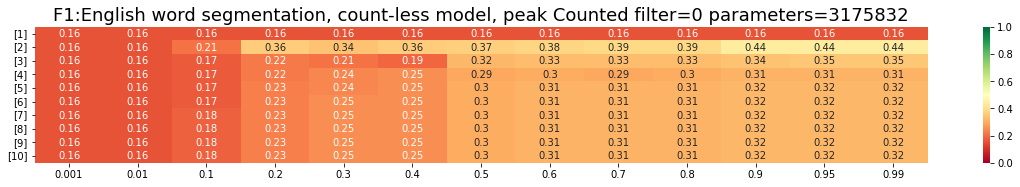

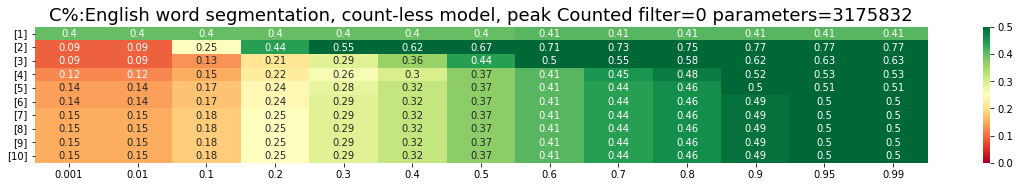

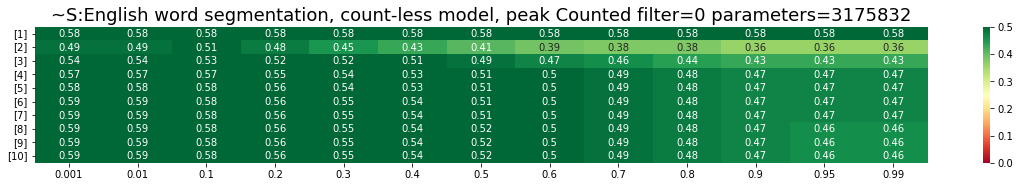

In [152]:
en_test_texts = [t for t in en_lex_dict if len(t) > 0]
en_test_counts = [en_lex_dict[t] for t in en_lex_dict if len(t) > 0]

metrics_en_list10_all_ = []

base = FreedomTokenizer(name='data/models/lex_en_counted_10_',max_n=7,mode='chars',debug=False)
title = 'English word segmentation, count-less model, peak'
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base.model,model_threshold)
    parameters = base.count_params()
    metrics = evaluate_freedom_tokenizer_multimetrics(en_test_texts,en_ref_tokenizer,FreedomBasedTokenizerWithWordBoundaries(base,'peak-','peak+'),
        ngram_params,token_thresholds,title="{} Counted filter={} parameters={}".format(title,model_threshold,parameters)
        ,test_counts=en_test_counts)
    metrics_en_list10_all_.extend([('peak',model_threshold,m[0],m[1],m[2],m[3],m[4]) for m in metrics])
del base


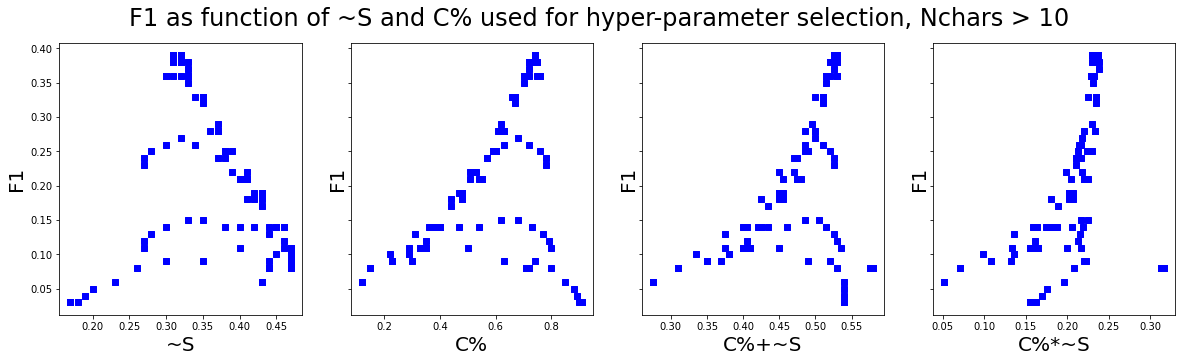

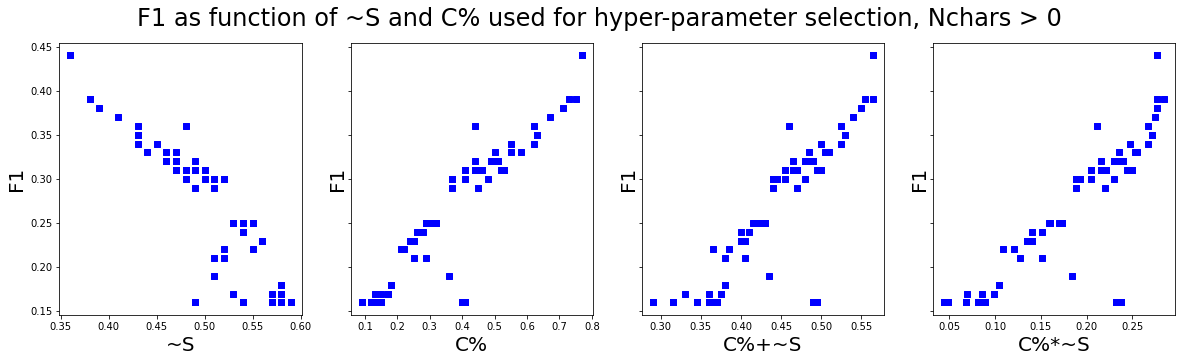

In [153]:
for metrics, l in zip([metrics_en_list10_10_,metrics_en_list10_all_],[10,0]):
    
    title = 'F1 as function of ~S and C% used for hyper-parameter selection, Nchars > '+str(l)

    m_df = pd.DataFrame(metrics,columns=['TM','MT','NG','TT','F1','C%','~S'])
    m_df['C%+~S'] = (m_df['C%'] + m_df['~S'])/2
    m_df['C%*~S'] = (m_df['C%'] * m_df['~S'])

    fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

    axs[0].scatter(m_df['~S'], m_df['F1'], c ="blue", marker ="s")
    axs[0].set_xlabel("~S",fontsize=20)
    axs[0].set_ylabel("F1",fontsize=20)

    axs[1].scatter(m_df['C%'], m_df['F1'], c ="blue", marker ="s")
    axs[1].set_xlabel("C%",fontsize=20)
    axs[1].set_ylabel("F1",fontsize=20)

    axs[2].scatter(m_df['C%+~S'], m_df['F1'], c ="blue", marker ="s")
    axs[2].set_xlabel("C%+~S",fontsize=20)
    axs[2].set_ylabel("F1",fontsize=20)

    axs[3].scatter(m_df['C%*~S'], m_df['F1'], c ="blue", marker ="s")
    axs[3].set_xlabel("C%*~S",fontsize=20)
    axs[3].set_ylabel("F1",fontsize=20)

    p = fig.suptitle(title,fontsize=24) 

## Summary
- word length up to 10 over 7 => saturation at 7, see https://github.com/aigents/pygents/blob/main/notebooks/nlp/morphology/morphology_lexicon_en_only.ipynb
- F1 on morpho-parsing does not exceed 0.42, see https://github.com/aigents/pygents/blob/main/notebooks/nlp/morphology/morphology_lexicon_en_only.ipynb
- direct dependence of F1 on compresssin factor, see https://github.com/aigents/pygents/blob/main/notebooks/nlp/morphology/morphology_lexicon_en_only.ipynb
- inverse dependence of F1 on anti-entropy (why!?), see https://github.com/aigents/pygents/blob/main/notebooks/nlp/morphology/morphology_lexicon_en_only.ipynb
- limiting training set by word frequency helps to improve morho-parsing F1 (0.0005-0.001 improves F1 from 0.24 o 0.28 on Table 4 in https://arxiv.org/pdf/2005.06606.pdf ), see https://github.com/aigents/pygents/blob/main/notebooks/nlp/morphology/morphology_lexicon_en_test.ipynb
- applying model compression threshold  helps to improve morho-parsing F1 on small corpus (0.1 improves F1 from 0.24 o 0.27 on Table 4 in https://arxiv.org/pdf/2005.06606.pdf ) but does not render noticable impact on fll lexicon, see https://github.com/aigents/pygents/blob/main/notebooks/nlp/morphology/morphology_lexicon_en_test.ipynb 



In [ ]:
#TODO compare and sum-up
# 0) account for word boundaries with _ letters with account to P (IN PROGRESS) 

# 1) try morpho-parsing on probabilities like transitions (on ref DPE-BPE corpus first)  
# 2) try morpho-parsing on "transitional cohesion" like mtual probabability (on ref DPE-BPE corpus first)
# 3) same experiment for russian
# 4) prefix-suffix based morpho-parser  
# 5) ref-lexicon based morpho-parser (no counts) 
# 6) ref-lexicon based morpho-parser (counted) 
# 7) learned tokenization-based morpho-parser (no counts)
# 8) learned tokenization-based morpho-parser (counted)

